## Preprocessing

Normally, you would pre-process your data. This includes loading the fits files, separating out the wavelengths, fluxes, uncertainties, and any masks. In addition, you would need to convert your data into the same units as your emulator. In our case, the PHOENIX emulator uses $A$ and $erg/cm^2/s/cm$. For this example, though, I've already created a spectrum that you can load directly.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from scipy import signal
import glob
from astropy.table import Table
import os
homedir = os.path.expanduser('~')
from Starfish.spectrum import Spectrum

In [5]:
filelist = sorted(glob.glob(f'{homedir}/uoedrive/data/IGRINS/SDCK*_1f.spec.fits'))

fluxes = []
wls = []
am = []

for filename in filelist:
    wlname = filename.split('_1f')[0]+'.wave.fits'

    flux = fits.getdata(filename)
    wl = fits.getdata(wlname)
    hdr = fits.getheader(filename)
    airmass = (hdr["AMSTART"] + hdr["AMEND"])/2
    # trim first and last 100 columns
    flux = flux[:, 100:1948]
    wl = wl[:, 100:1948]
    
    fluxes.append(flux)
    wls.append(wl)
    am.append(airmass)
dims = np.array(fluxes).shape
fluxes = np.array(fluxes)
wls = np.array(wls)

obs0 = np.median(fluxes[:, 1:, :], axis=0)*dims[0]  # make mean spectrum
eobs0 = np.median(fluxes[:, 1:, :], axis=0)*np.sqrt(dims[0])  # make mean noise spectrum (assuming just photon noise)
fobs0 = np.vstack([signal.medfilt(obs0[jj], 3) for jj in range(dims[1]-1)])  # smooth spectrum
#fobs0 /= np.nanmedian(fobs0, 1).reshape(dims[1]-1,1)

# fix wavelength array to have same shape
wls = wls[:, 1:24, :] 

<AxesSubplot: title={'center': 'Spectrum'}, xlabel='$\\lambda$ [$\\AA$]', ylabel='$f_\\lambda$ [$erg/cm^2/s/cm$]'>

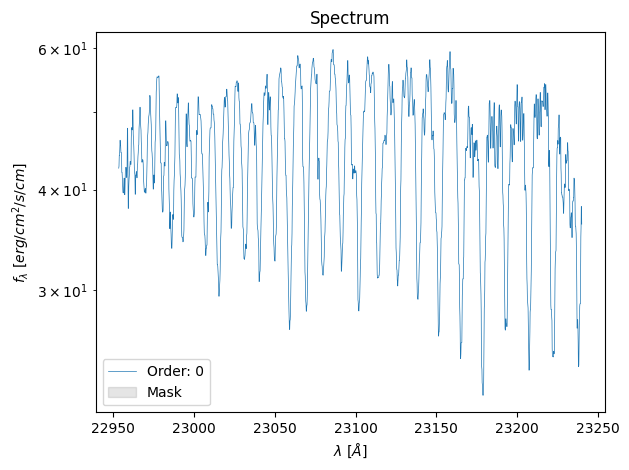

In [6]:
obs=22
order=5
wl_order = wls[obs, order, :] *10000
flux_order = fobs0[order]
data = Spectrum(wl_order, flux_order, sigmas=None, masks=None, name="Spectrum")
data.plot()
#fitted params:
# chisq = 346
# vsini = 30.45525347753552
# rv = 0.8606
# lld = 8.589e-05
# wcoef = [ 0.00024143 -0.00397479  0.03418952], [ 0.00024143 -0.00397479  0.03418952], [ 0.0002946  -0.00408566  0.03425189], [ 0.0002946  -0.00408566  0.03425189]
# ccoef = [2.45280359 0.2117408 ], [2.45280359 0.2117408 ]

## Setting up the model

Now we can set up our initial model. We need, at minimum, an emulator, our data, and a set of the library grid parameters. Every extra keyword argument we add is added to our list of parameters. For more information on what parameters are available and what effect they have, see the [SpectrumModel documentation](../api/models.rst#SpectrumModel).

Some of these parameters are based on guesses or pre-existing knowledge. In particular, if you want to fit `log_scale`, you should spend some time tuning it by eye, first. We also want our `global_cov:log_amp` to be reasonable, so pay attention to the $\sigma$-contours in the residuals plots, too.

There aren't any previous in-depth works on this star, so we will start with some values based on the spectral type alone.

SpectrumModel
-------------
Data: Spectrum
Emulator: BTSettl_K_emu
Log Likelihood: None

Parameters
  vsini: 25
  vz: 105
  T: 1500
  logg: 5.0
  log_scale: 3.9347589124169167 (fit)

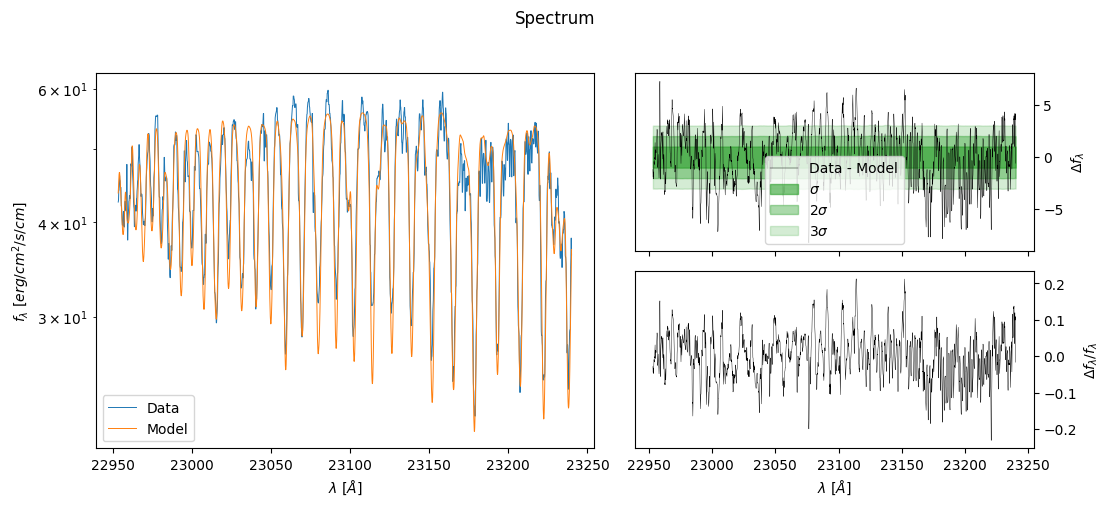

In [7]:
from Starfish.models import SpectrumModel

model = SpectrumModel(
    emulator="BTSettl_K_emu.hdf5",
    data=data,
    grid_params=[1500, 5.0],
    vsini=25,
    vz=105,
    #cheb=[0.5]
)
model.plot()
model

## Numerical Optimization

Now lets do a *maximum a posteriori* (MAP) point estimate for our data. 

In [8]:
model.freeze("logg")
model.labels  # These are the fittable parameters

('vsini', 'vz', 'T')

Here we specify some priors using `scipy.stats` classes. If you have a custom distribution you want to use, create a class and make sure it has a `logpdf` member function.

In [89]:
import scipy.stats as st

priors = {
    "T": st.norm(1500, 100),
    "vsini": st.norm(25, 0.2),
    "global_cov:log_amp": st.norm(0, 1),
    "global_cov:log_ls": st.uniform(0, 10),
}

In [12]:
import scipy.stats as st
priors = {
    "T": st.norm(1500,100),
    "vsini": st.uniform(0, 50),
    "vz": st.uniform(10, 100),
    #"cheb:1": st.norm(1, 0.1)
}

Using the above priors, we can do our MAP optimization using `scipy.optimize.minimze`, which is usefully baked into the `train` method of our model. This should give us a good starting point for our MCMC sampling later. 

In [13]:
%time model.train(priors, options={"maxiter":1000})

KeyboardInterrupt: 

In [14]:
model

SpectrumModel
-------------
Data: Spectrum
Emulator: BTSettl_K_emu
Log Likelihood: -4572.914613654655

Parameters
  vsini: 27.84554765597424
  vz: 104.43066110124646
  T: 1489.9391824042355
  log_scale: 3.953527829595361 (fit)

Frozen Parameters
  logg: 5.0

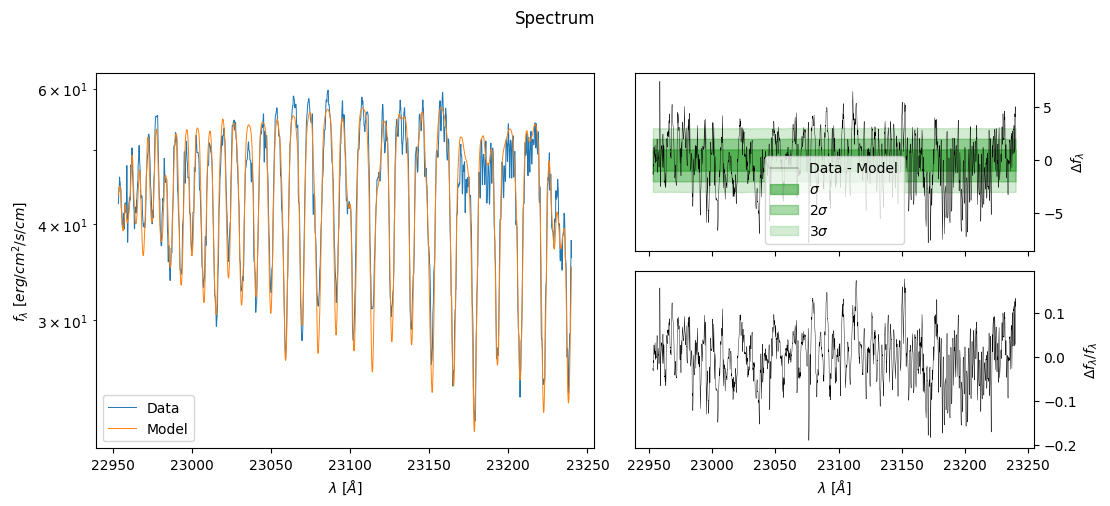

In [15]:
model.plot();

In [16]:
model.save("example_MAP_1.toml")

## MCMC Sampling

Now, we will sample from our model. Note the flexibility we provide with *Starfish* in order to allow sampler front-end that allows blackbox likelihood methods. In our case, we will continue with [emcee](https://github.com/dfm/emcee), which provides an ensemble sampler. We are using pre-release of version `3.0`. This document serves only as an example, and details about emcee's usage should be sought after in its [documentation](https://emcee.readthedocs.io/en/latest/).

For this basic example, I will freeze both the global and local covariance parameters, so we are only sampling over `T`, `Z`, and `Av`.

In [17]:
import emcee

emcee.__version__

'3.1.3'

In [18]:
model.load("example_MAP.toml")
#model.freeze("global_cov")
model.labels

('vsini', 'vz', 'T')

In [22]:
import numpy as np

# Set our walkers and dimensionality
nwalkers = 10
ndim = len(model.labels)

# Initialize gaussian ball for starting point of walkers
scales = {"T": 1, "vsini": 1, "vz": 1}

ball = np.random.randn(nwalkers, ndim)

for i, key in enumerate(model.labels):
    ball[:, i] *= scales[key]
    ball[:, i] += model[key]

In [23]:
# our objective to maximize
def log_prob(P, priors):
    model.set_param_vector(P)
    return model.log_likelihood(priors)


# Set up our backend and sampler
backend = emcee.backends.HDFBackend("example_chain.hdf5")
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(priors,), backend=backend
)

here we start our sampler, and following [this example](https://emcee.readthedocs.io/en/latest/tutorials/monitor/#saving-monitoring-progress) we check every 10 steps for convergence, with a max burn-in of 1000 samples.

<div class="alert alert-warning">

**Warning:** This process *can* take a long time to finish. In cases with high resolution spectra or fully evaluating each nuisance covariance parameter, we recommend running on a remote machine. A setup I recommend is a remote jupyter server, so you don't have to create any scripts and can keeping working in notebooks.

</div>

In [24]:
max_n = 500

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf


# Now we'll sample for up to max_n steps
for sample in sampler.sample(ball, iterations=max_n, progress=True):
    # Only check convergence every 10 steps
    if sampler.iteration % 10:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1
    # skip math if it's just going to yell at us
    if np.isnan(tau).any() or (tau == 0).any():
        continue
    # Check convergence
    converged = np.all(tau * 10 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        print(f"Converged at sample {sampler.iteration}")
        break
    old_tau = tau

  0%|                                                   | 0/500 [00:00<?, ?it/s]/Users/xqchen/workspace/dopplerimg/venv/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▊                                         | 10/500 [01:13<54:50,  6.72s/it]/Users/xqchen/workspace/dopplerimg/venv/lib/python3.9/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]
 76%|█████████████████████████████▋         | 380/500 [1:04:57<20:30, 10.26s/it]

Converged at sample 380


After our model has converged, let's take a few extra samples to make sure we have clean chains. Remember, we have 50 walkers, so 100 samples ends up becoming 5000 across each chain!

In [25]:
sampler.run_mcmc(backend.get_last_sample(), 50, progress=True);

100%|███████████████████████████████████████████| 50/50 [07:58<00:00,  9.56s/it]


## MCMC Chain Analysis

Chain analysis is a very broad topic that is mostly out of the scope of this example. 
For our analysis, we like using [ArviZ](https://github.com/arviz-devs/arviz) with a simple [corner](https://github.com/dfm/corner.py) plot as well. 

In [26]:
import arviz as az
import corner

print(az.__version__, corner.__version__)

0.13.0 2.2.1


In [27]:
reader = emcee.backends.HDFBackend("example_chain.hdf5")
full_data = az.from_emcee(reader, var_names=model.labels)

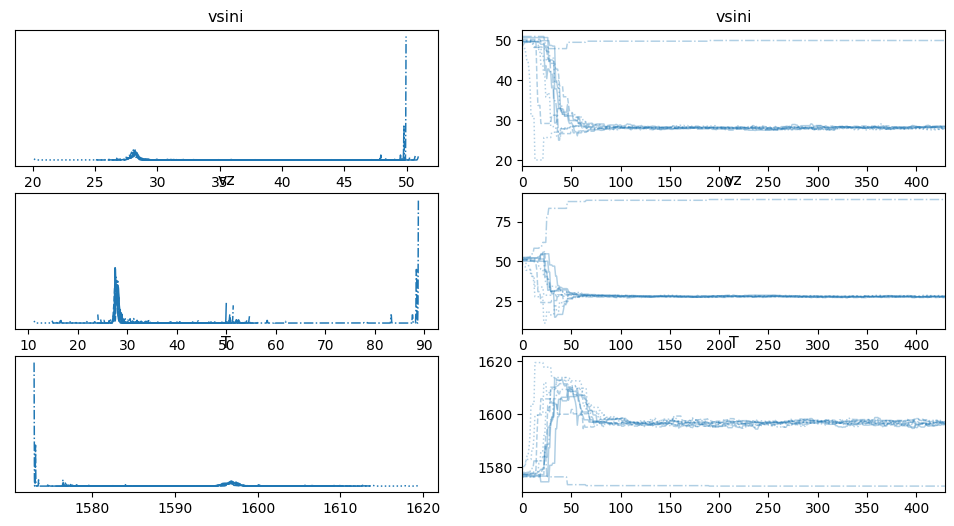

In [28]:
az.plot_trace(full_data);

After seeing our full traces, let's discard and thin some of the burn-in

In [29]:
tau = reader.get_autocorr_time(tol=0)
burnin = int(tau.max())
thin = int(0.3 * np.min(tau))
burn_samples = reader.get_chain(discard=burnin, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, thin=thin)

dd = dict(zip(model.labels, burn_samples.T))
burn_data = az.from_dict(dd)

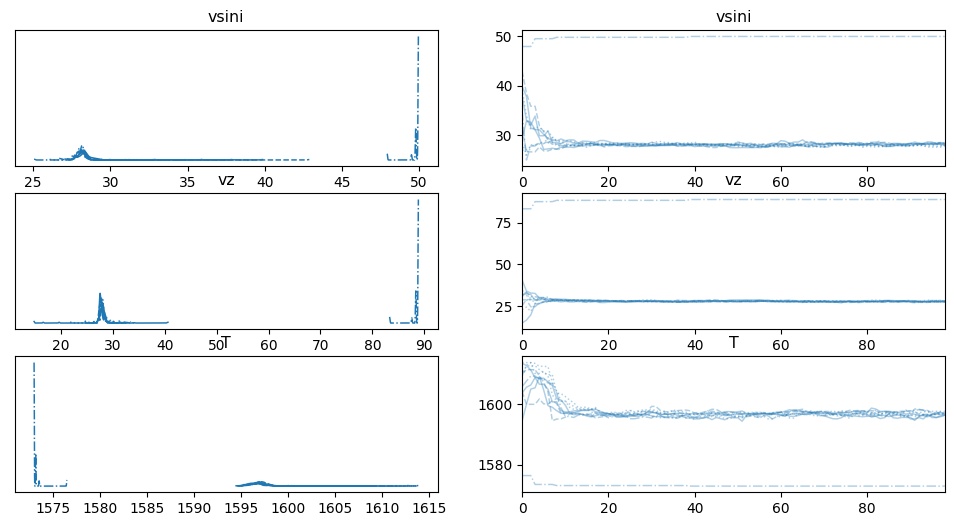

In [30]:
az.plot_trace(burn_data);

In [31]:
az.summary(burn_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
vsini,30.471,6.557,27.701,49.965,1.981,1.446,21.0,211.0,1.42
vz,33.987,18.209,27.350,88.876,5.571,4.056,22.0,261.0,1.43
T,1595.341,8.053,1572.955,1603.801,2.295,1.663,25.0,12.0,1.33


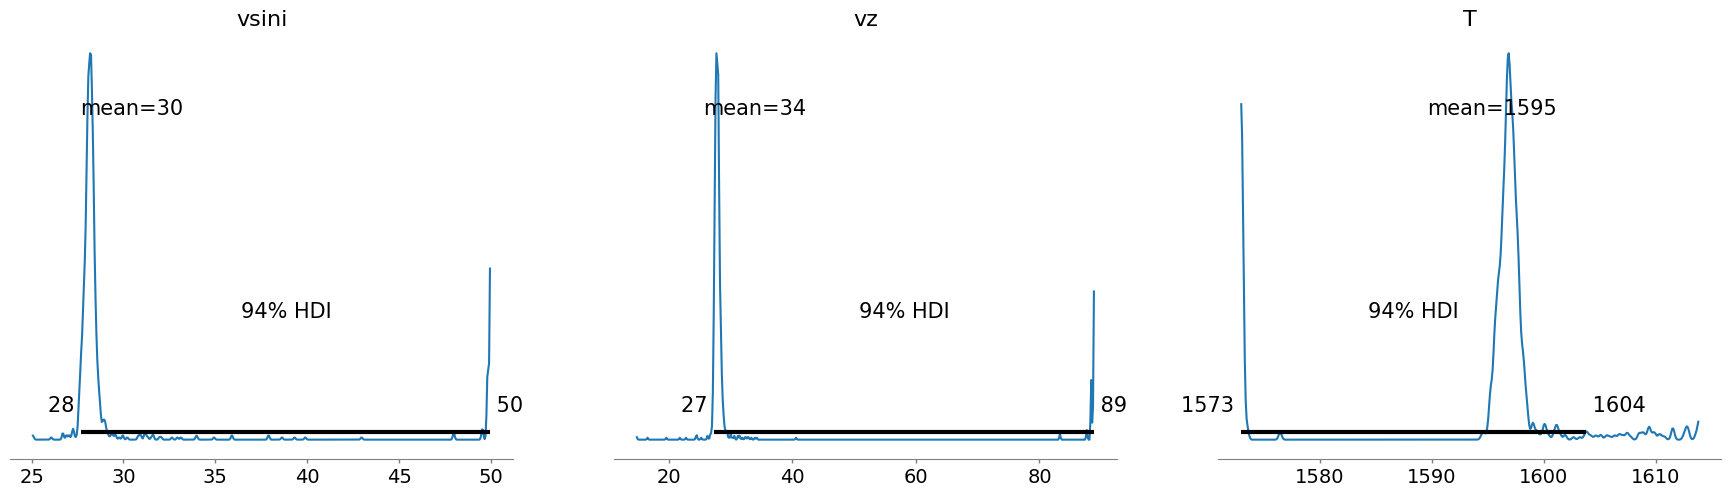

In [32]:
az.plot_posterior(burn_data, ["vsini", "vz", "T"]);

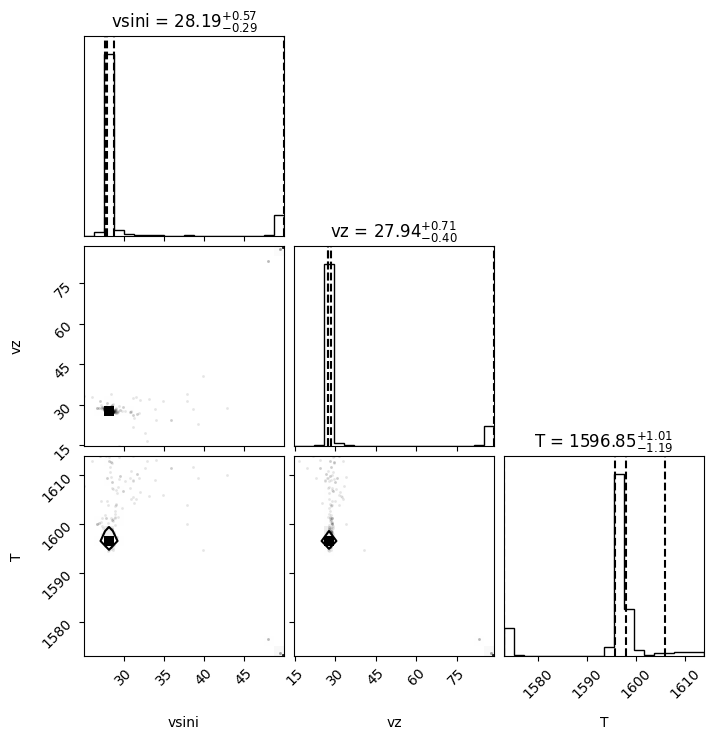

In [33]:
# See https://corner.readthedocs.io/en/latest/pages/sigmas.html#a-note-about-sigmas
sigmas = ((1 - np.exp(-0.5)), (1 - np.exp(-2)))
corner.corner(
    burn_samples.reshape((-1, 3)),
    labels=model.labels,
    quantiles=(0.05, 0.16, 0.84, 0.95),
    levels=sigmas,
    show_titles=True,
);

After looking at our posteriors, let's look at our fit

In [34]:
best_fit = dict(az.summary(burn_data)["mean"])
model.set_param_dict(best_fit)
model

SpectrumModel
-------------
Data: Spectrum
Emulator: BTSettl_K_emu
Log Likelihood: -67698.90203469207

Parameters
  vsini: 30.471
  vz: 33.987
  T: 1595.341
  log_scale: 3.830919637475494 (fit)

Frozen Parameters
  logg: 5.0

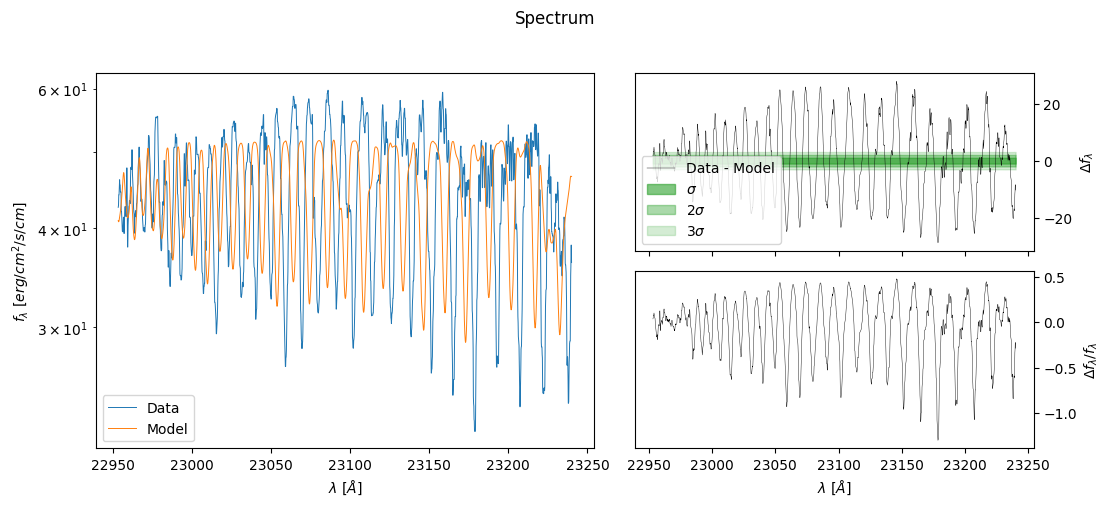

In [35]:
model.plot();

and finally, we can save our best fit.

In [36]:
model.save("example_sampled_1.toml")

Now, on to the next star!